# Fine-Tuning YOLOv11s for Face Detection on Face-Detection-Dataset

This notebook fine-tunes YOLOv11s on the Face-Detection-Dataset from Kaggle for face detection.
- **Dataset**: 16.7k images with bounding box annotations in YOLO format.
- **Model**: YOLOv11s (pre-trained on COCO, fine-tuned for face detection).
- **Output**: Save the fine-tuned model weights to Google Drive.

In [1]:
# Install Ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
# Import libraries
import cv2
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
import os
import shutil
import torch
from ultralytics import YOLO
%matplotlib inline

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


In [3]:
# Upload kaggle.json
uploaded = files.upload()  # Upload kaggle.json

# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
# Download Face-Detection-Dataset dataset from Kaggle
!kaggle datasets download -d fareselmenshawii/face-detection-dataset

# Unzip the dataset
!unzip face-detection-dataset.zip -d face-detection-dataset

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: face-detection-dataset/labels2/b0a96b76a58c433c.txt  
  inflating: face-detection-dataset/labels2/b0abd92b73ecb406.txt  
  inflating: face-detection-dataset/labels2/b0b880a17aeb2905.txt  
  inflating: face-detection-dataset/labels2/b0b9a9952976e42b.txt  
  inflating: face-detection-dataset/labels2/b0bfe0f426275870.txt  
  inflating: face-detection-dataset/labels2/b0c2f74e1fed9b71.txt  
  inflating: face-detection-dataset/labels2/b0c4491f61005387.txt  
  inflating: face-detection-dataset/labels2/b0c4ccd19b83f4c6.txt  
  inflating: face-detection-dataset/labels2/b0c66e943f050df1.txt  
  inflating: face-detection-dataset/labels2/b0c9eb2a1f9aa986.txt  
  inflating: face-detection-dataset/labels2/b0cf4af0df03be90.txt  
  inflating: face-detection-dataset/labels2/b0d51a66b2c3abeb.txt  
  inflating: face-detection-dataset/labels2/b0d9501aa2380861.txt  
  inflating: face-detection-dataset/labels2/b0d97c088f04e8b1.txt  
  i

In [5]:
# Mount Google Drive to save the model
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Define paths
dataset_root = 'face-detection-dataset'
train_images_dir = os.path.join(dataset_root, 'images', 'train')
val_images_dir = os.path.join(dataset_root, 'images', 'val')
train_labels_dir = os.path.join(dataset_root, 'labels', 'train')
val_labels_dir = os.path.join(dataset_root, 'labels', 'val')

# Verify dataset paths
print(f"Training images directory exists: {os.path.exists(train_images_dir)}")
print(f"Validation images directory exists: {os.path.exists(val_images_dir)}")
print(f"Training labels directory exists: {os.path.exists(train_labels_dir)}")
print(f"Validation labels directory exists: {os.path.exists(val_labels_dir)}")

Training images directory exists: True
Validation images directory exists: True
Training labels directory exists: True
Validation labels directory exists: True


In [7]:
# Create the dataset.yaml file for YOLOv8
dataset_yaml = """
path: /content/face-detection-dataset
train: images/train
val: images/val
names:
  0: face
"""

# Save the dataset.yaml file
with open('dataset.yaml', 'w') as f:
    f.write(dataset_yaml)
print("Created dataset.yaml for YOLOv11 training.")

Created dataset.yaml for YOLOv11 training.


In [8]:
# Inspect a sample label file to confirm the format
sample_label_path = os.path.join(val_labels_dir, '0003d5dfa8f0dd41.txt')
if os.path.exists(sample_label_path):
    with open(sample_label_path, 'r') as f:
        print(f"Sample label file ({sample_label_path}):")
        print(f.read())
else:
    print("Sample label file not found. Please check the dataset paths.")

Sample label file (face-detection-dataset/labels/val/0003d5dfa8f0dd41.txt):
0 0.1972265625 0.154722 0.09625 0.125556
0 0.4355078125 0.3734721111111111 0.13625000000000004 0.28666699999999995
0 0.7503515625 0.2258337777777778 0.09624999999999995 0.182222



In [ ]:
# Load the pre-trained YOLOv8s model
model = YOLO("yolo11s.pt")

# Fine-tune the model on the face detection dataset
results = model.train(
    data='dataset.yaml',  # Path to the dataset configuration
    epochs=16,            # Number of epochs (adjust based on dataset size and convergence)
    imgsz=640,            # Image size (YOLOv11 default)
    batch=32,             # Batch size (adjust based on GPU memory)
    device=device,        # Use GPU if available
    name='yolo11_face_detection',# Experiment name
    patience=2            # Early stopping if no improvement after 2 epochs
)

100%|██████████| 18.4M/18.4M [00:00<00:00, 362MB/s]


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=16, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11_face_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=2, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False, sav

100%|██████████| 755k/755k [00:00<00:00, 138MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    443776  ultralytics.nn.modules.block.C3k2            [768, 256, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    127680  ultralytics.nn.modules.block.C3k2            [512,

100%|██████████| 5.35M/5.35M [00:00<00:00, 266MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 320.4±627.7 MB/s, size: 229.5 KB)


train: Scanning /content/face-detection-dataset/labels/train... 13386 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13386/13386 [00:24<00:00, 543.64it/s] 


train: New cache created: /content/face-detection-dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 836.1±668.8 MB/s, size: 308.9 KB)


val: Scanning /content/face-detection-dataset/labels/val... 3347 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3347/3347 [00:03<00:00, 880.39it/s] 


val: New cache created: /content/face-detection-dataset/labels/val.cache
Plotting labels to runs/detect/yolo11_face_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11_face_detection
Starting training for 16 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/16      8.88G      1.366      1.266      1.204         48        640: 100%|██████████| 419/419 [05:51<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:49<00:00,  1.07it/s]


                   all       3347      10299      0.745       0.64      0.668      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/16      8.96G       1.32     0.8801      1.158         30        640: 100%|██████████| 419/419 [05:53<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:47<00:00,  1.12it/s]


                   all       3347      10299      0.871      0.721      0.804      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/16      8.64G      1.293     0.8448      1.143         58        640: 100%|██████████| 419/419 [05:38<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:47<00:00,  1.11it/s]


                   all       3347      10299      0.867      0.731      0.808      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/16      8.54G      1.272     0.8145      1.132         74        640: 100%|██████████| 419/419 [05:34<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:48<00:00,  1.10it/s]


                   all       3347      10299       0.87      0.756      0.826       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/16      8.82G      1.247     0.7731      1.114         50        640: 100%|██████████| 419/419 [05:24<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:41<00:00,  1.28it/s]


                   all       3347      10299       0.87      0.768      0.835      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/16       8.6G       1.22     0.7375      1.104         37        640: 100%|██████████| 419/419 [05:14<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:42<00:00,  1.26it/s]


                   all       3347      10299      0.883      0.774      0.849      0.546
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/16      8.81G      1.223     0.7146       1.11         33        640: 100%|██████████| 419/419 [05:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:40<00:00,  1.31it/s]


                   all       3347      10299      0.883       0.76       0.84      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/16      9.03G      1.204     0.6838      1.102         27        640: 100%|██████████| 419/419 [04:56<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:41<00:00,  1.29it/s]


                   all       3347      10299      0.883      0.781      0.858       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/16      8.76G      1.191     0.6589      1.088         43        640: 100%|██████████| 419/419 [04:57<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:40<00:00,  1.31it/s]

                   all       3347      10299      0.885      0.785      0.863      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/16      9.17G      1.178     0.6395      1.082         16        640: 100%|██████████| 419/419 [04:56<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:40<00:00,  1.31it/s]


                   all       3347      10299      0.885      0.795      0.869       0.56

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/16      8.97G      1.164     0.6223      1.074         20        640: 100%|██████████| 419/419 [04:54<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:40<00:00,  1.31it/s]


                   all       3347      10299      0.886      0.803      0.873      0.578

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/16       8.6G       1.15     0.6035      1.067         23        640: 100%|██████████| 419/419 [04:55<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:40<00:00,  1.31it/s]

                   all       3347      10299      0.884       0.81       0.88      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/16      8.59G      1.139     0.5873      1.056         19        640: 100%|██████████| 419/419 [04:58<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:46<00:00,  1.15it/s]


                   all       3347      10299       0.88      0.816      0.881      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/16      8.55G      1.127     0.5686      1.053         34        640: 100%|██████████| 419/419 [05:17<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:44<00:00,  1.19it/s]


                   all       3347      10299      0.892      0.809      0.884      0.589

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/16      9.27G      1.116     0.5539      1.046         26        640: 100%|██████████| 419/419 [05:24<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:44<00:00,  1.19it/s]


                   all       3347      10299      0.893      0.815      0.888      0.595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/16      8.45G      1.101      0.533      1.038         20        640: 100%|██████████| 419/419 [05:21<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:44<00:00,  1.18it/s]


                   all       3347      10299      0.893      0.822      0.891      0.597

16 epochs completed in 1.612 hours.
Optimizer stripped from runs/detect/yolo11_face_detection/weights/last.pt, 19.1MB
Optimizer stripped from runs/detect/yolo11_face_detection/weights/best.pt, 19.1MB

Validating runs/detect/yolo11_face_detection/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:47<00:00,  1.12it/s]


                   all       3347      10299      0.892      0.823      0.891      0.597
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/yolo11_face_detection


In [10]:
# Quick validation: Test the fine-tuned model on a few validation images
# Custom Dataset class for validation (same as before)
class FaceDetectionDataset:
    def __init__(self, images_dir, labels_dir):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            return None, [], img_path
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_height, img_width = img.shape[:2]

        # Load ground truth bounding boxes from labels/val (YOLO format)
        label_path = os.path.join(self.labels_dir, self.image_files[idx].replace('.jpg', '.txt'))
        bboxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        print(f"Warning: Invalid line format in {label_path}: {line.strip()}")
                        continue
                    try:
                        class_id, center_x, center_y, width, height = map(float, parts)
                        x_min = (center_x - width / 2) * img_width
                        y_min = (center_y - height / 2) * img_height
                        x_max = (center_x + width / 2) * img_width
                        y_max = (center_y + height / 2) * img_height
                        bboxes.append([x_min, y_min, x_max, y_max])
                    except ValueError as e:
                        print(f"Error parsing line in {label_path}: {line.strip()} - {e}")
                        continue

        return img_rgb, bboxes, img_path

# Load validation dataset
val_dataset = FaceDetectionDataset(val_images_dir, val_labels_dir)
print(f"Validation set size: {len(val_dataset)} images")

Validation set size: 3347 images



0: 384x640 3 faces, 92.0ms
Speed: 8.1ms preprocess, 92.0ms inference, 6.2ms postprocess per image at shape (1, 3, 384, 640)


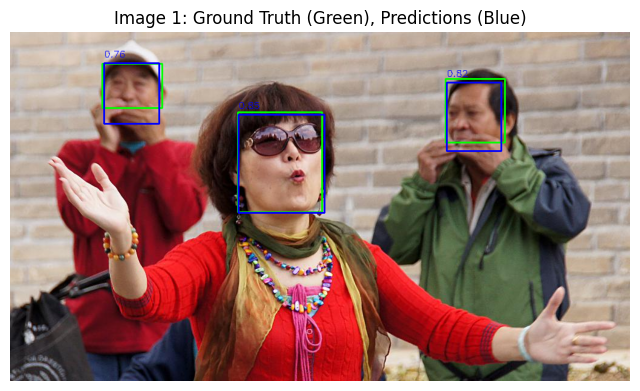


0: 448x640 2 faces, 119.6ms
Speed: 5.4ms preprocess, 119.6ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


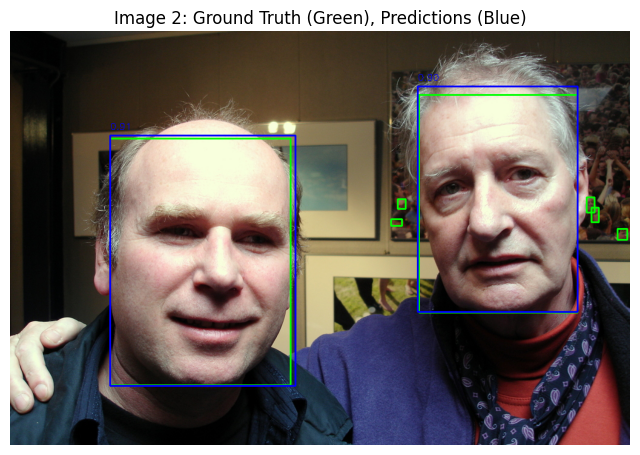


0: 640x448 1 face, 100.9ms
Speed: 3.9ms preprocess, 100.9ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 448)


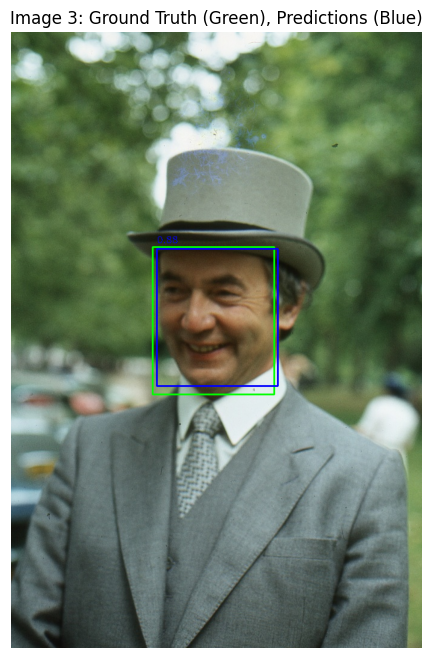


0: 480x640 4 faces, 82.8ms
Speed: 4.2ms preprocess, 82.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


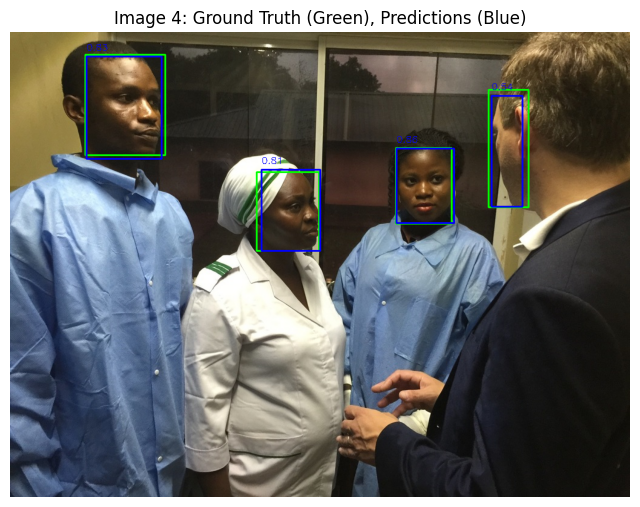


0: 640x640 2 faces, 20.9ms
Speed: 7.9ms preprocess, 20.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


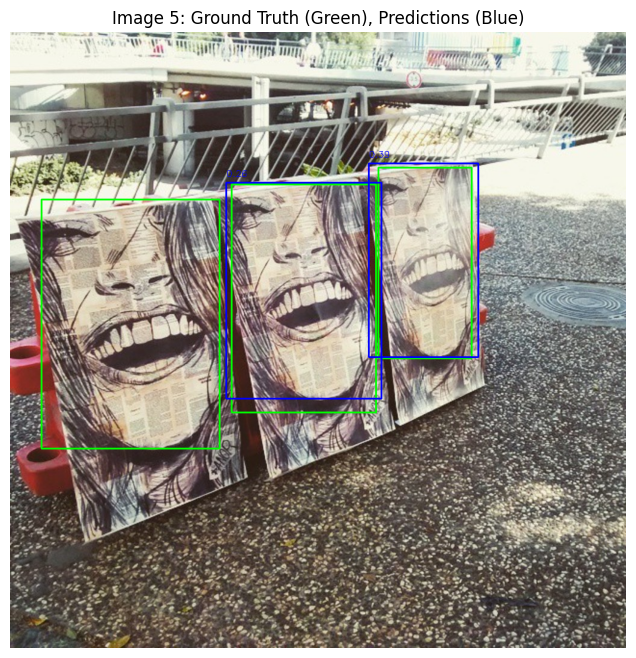

In [11]:
# Visualize predictions for the first 5 validation images
confidence_threshold = 0.25

for idx in range(min(5, len(val_dataset))):
    img, gt_bboxes, img_path = val_dataset[idx]
    if img is None:
        continue

    # Run face detection with the fine-tuned model
    results = model(img, imgsz=640, conf=confidence_threshold, device=device)

    # Draw ground truth boxes
    img_with_boxes = img.copy()
    for gt_bbox in gt_bboxes:
        x_min, y_min, x_max, y_max = map(int, gt_bbox)
        cv2.rectangle(img_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green for ground truth

    # Draw predicted boxes
    for box in results[0].boxes:
        x_min, y_min, x_max, y_max = map(int, box.xyxy[0].cpu().numpy())
        score = box.conf.item()  # Use .item() to get scalar float
        class_id = box.cls.item()  # Use .item() to get scalar int
        if class_id == 0:  # Only plot face detections (class 0 is 'face')
            cv2.rectangle(img_with_boxes, (x_min, y_min), (x_max, y_max), (0, 0, 255), 2)  # Light Blue for predictions
            cv2.putText(img_with_boxes, f"{score:.2f}", (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(img_with_boxes)
    plt.title(f"Image {idx+1}: Ground Truth (Green), Predictions (Blue)")
    plt.axis('off')
    plt.show()

In [12]:
training_results_dir = "runs/detect/yolo11_face_detection"
drive_save_path = "/content/drive/MyDrive/[Sem. 7 & 8] Seminar & Skripsi/Program/Model/YOLOv11s_Face_Detection"

# Create the save directory in Google Drive if it doesn't exist
os.makedirs(drive_save_path, exist_ok=True)

In [13]:
# Copy the training results to Google Drive
shutil.copytree(training_results_dir, os.path.join(drive_save_path, "yolo11_face_detection"), dirs_exist_ok=True)
print(f"Training results saved to {drive_save_path}/yolo11_face_detection")

Training results saved to /content/drive/MyDrive/[Sem. 7 & 8] Seminar & Skripsi/Program/Model/YOLOv11s_Face_Detection/yolo11_face_detection
